In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys

if "../" not in sys.path:
    sys.path.append("../")

from collections import defaultdict
from lib.envs.cliff_walking import CliffWalkingEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = CliffWalkingEnv()

In [7]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [8]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, nA)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        state = env.reset()
        prob = policy(state)
        done = False
        rewardAll = 0
        for t in itertools.count():
            action = np.random.choice(range(nA), p=prob)
            next_state, reward, done, _ = env.step(action)
            prob = policy(next_state)
            rewardAll += reward
            Q[state][action] += alpha*(reward + discount_factor*np.max(Q[next_state])-Q[state][action])
            if done:
                break
            state = next_state
        stats.episode_lengths[i_episode] = t
        stats.episode_rewards[i_episode] = rewardAll
    
    return Q, stats

In [9]:
Q, stats = q_learning(env, 500)

Episode 500/500.

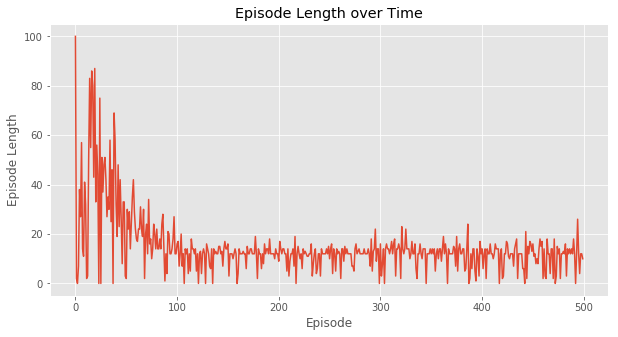

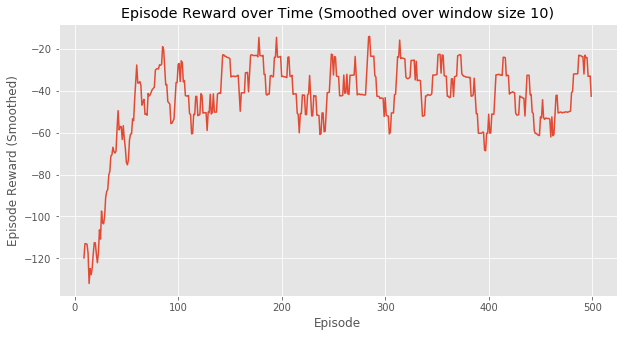

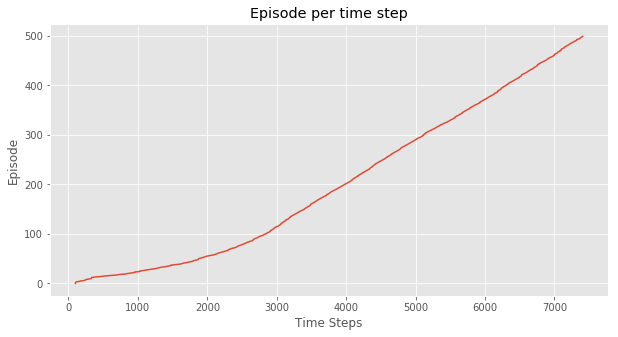

(<matplotlib.figure.Figure at 0x7f9968c6c240>,
 <matplotlib.figure.Figure at 0x7f9966b7c898>)

In [10]:
plotting.plot_episode_stats(stats)

In [11]:
# Animate the solution path
import time
from IPython.display import clear_output

def make_greedy_policy(Q, nA):
    def policy_fn(observation):
        A = np.zeros(nA, dtype=float)
        A[np.argmax(Q[observation])] = 1.0
        return A
    return policy_fn
state = env.reset()
env.render()
time.sleep(0.6)
clear_output(wait=True)
policy = make_greedy_policy(Q, env.action_space.n)
while True:
    prob = policy(state)
    action = np.random.choice(range(env.action_space.n), p=prob)
    next_state, _, done, _ = env.step(action)
    env.render()
    time.sleep(0.3)
    clear_output(wait=True)
    if done:
        break
    state = next_state

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x



In [4]:
# Inteactive game mod. Use wasd to control.

def get_action():
    while(1):
        k=input("-->")
        if k!='':break
    if k=='w':
        return 0
    elif k=='s':
        return 2
    elif k=='d':
        return 1
    elif k=='a':
        return 3
    else:
        print("not an arrow key!")

state = env.reset()
env.render()
clear_output(wait=True)
while True:
    action = get_action()
    next_state, _, done, _ = env.step(action)
    env.render()
    clear_output(wait=True)
    if done:
        break
    state = next_state

-->s
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

